In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.table import QTable

# Tabla de miembros:

In [341]:
members = QTable.read('./../data/raw/members.fit')
members = members.to_pandas()

# Tabla de clusters:

In [342]:
clusters = QTable.read('./../data/raw/clusters.fit')
clusters = clusters.to_pandas()
clusters = clusters.sort_values(by='N', ascending=False)

# Tabla de distancias

Esta tabla es recuperada de la tabla `external.gaiaedr3_distance`, donde las distancias son dadas en $\text{pc}$.

In [343]:
distance_members = QTable.read('./../data/raw/distances.fits')
distance_members = distance_members.to_pandas()

# Datos pedidos

In [344]:
clusters.iloc[1]

Name        b'NGC_5139'
ID                 4649
N                 65987
RA_ICRS      201.737709
DE_ICRS      -47.306823
pmRA          -3.256655
pmDE          -6.769216
Plx             0.15879
X          -4903.812034
Y          -3947.792938
Z           1389.605848
RV           233.562554
MassTot             NaN
_RA_icrs      201.73773
_DE_icrs     -47.306793
recno              4643
Name: 4642, dtype: object

La tabla de cúmulos se organizó de mayor a menos número de miembros. El `.loc` escoge el cúmulo que es la fila $i$, y la ascensión recta y la declinación que son las columnas 3 y 4 de la tabla. 

Según el catálogo este es el punto más denso del cúmulo.

In [345]:
ra0 = clusters.iloc[1, 3]
dec0 = clusters.iloc[1, 4]

## Recolección de datos pedidos

Se crea una tabla con todos los datos del respectivo cúmulo:

In [346]:
cluster_members = members[members['Name'] == clusters.iloc[1, 0]]

Se agrega las distancias de cada respectiva estrella a la anterior tabla:

In [347]:
cluster_members = pd.merge(cluster_members, distance_members, how='left', on='GaiaDR3')

## Figura del cúmulo

Text(0, 0.5, 'Dec [deg]')

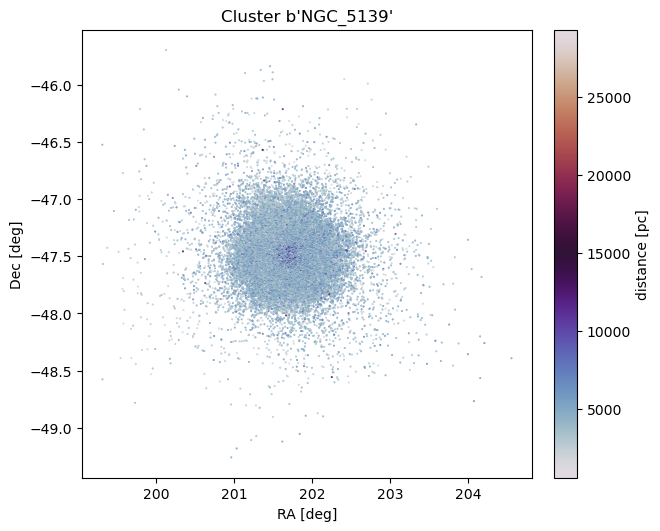

In [348]:
fig, ax = plt.subplots(figsize=(6.5, 5.2), constrained_layout=True)
cs = ax.scatter(
    cluster_members['RA_ICRS'],
    cluster_members['DE_ICRS'],
    c = cluster_members['r_med_geo'],
    s=0.2,
    vmin=min(cluster_members['r_med_geo']),
    vmax=max(cluster_members['r_med_geo']),
    cmap='twilight',
)

cb = fig.colorbar(cs)
cb.set_label("distance [pc]")

ax.set_title(f"Cluster {cluster_members['Name_x'][0]}")
ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")

# Cálculo de la densidad de área del cúmulo

Se calcula la distancia de los miembros al punto más denso del cúmulo usando la siguiente fórmula: $$\cos{c} = \cos{a}\cos{b} + \sin{a}\sin{b}\cos{C}$$ donde $c$ sería la distancia que se quiere encontrar.

In [349]:
a = np.deg2rad(90 - dec0)
b = np.deg2rad(90 - cluster_members['DE_ICRS'])
C = np.deg2rad(ra0 - cluster_members['RA_ICRS'])

cosc = np.cos(a)*np.cos(b) + np.sin(a)*np.sin(b)*np.cos(C)
c = np.arccos(cosc)

cluster_distance_members = np.rad2deg(c)

Se crea un dataframe para concatenarlo a la tabla de miembros del cúmulo:

In [350]:
d_members = pd.DataFrame(
    {'d_members': cluster_distance_members}
)

Se halla la máxima distancia:

In [351]:
d_max = max(cluster_distance_members)

Se generan los radios hasta la distancia máxima para calcular la densidad de área por anillos:

In [352]:
rs = np.linspace(0, d_max, 50)

In [353]:
# calcula los radios medios de cada anillo
def mean_radii(radii):
    return (radii[1:] + radii[:-1])/2

# calcula el área de cada anillo
def ring_areas(radii):
    area0 = np.pi * radii[:-1]**2
    area1 = np.pi * radii[1:]**2
    return area1 - area0

# calcula la densidad de número de miembros en cada anillo
def ring_densities(areas, distances, radii):
    counts = np.zeros(len(areas))
    for i in range(len(radii)-1):
        count = 0
        for j in range(len(distances)):
            if radii[i] < distances[j] and distances[j] <= radii[i+1]:
                count += 1
        counts[i] = count
    return counts/areas

# calcula el respectivo dato pedido de los miembros en cada anillo
def data(name, radii, distances, data_frame):
    mean_data = np.zeros(len(radii)-1)
    for i in range(len(radii)-1):
        data_ = []
        for j in range(len(distances)):
            if radii[i] < distances[j] and distances[j] <= radii[i+1]:
                data_.append(data_frame[name][i].value)
        mean_data[i] = np.mean(data_)
    return mean_data

# Densidad de número

In [354]:
radii = mean_radii(rs)
areas = ring_areas(rs)
densities = ring_densities(areas, cluster_distance_members, rs)

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


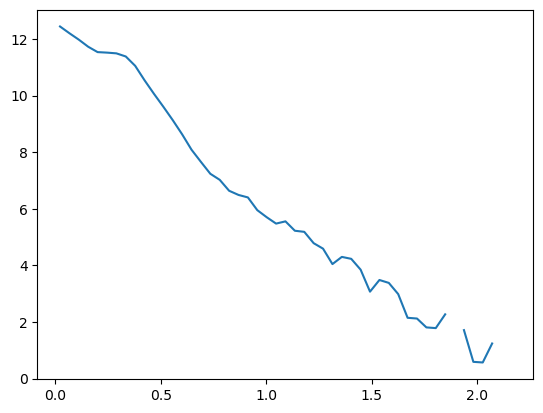

In [355]:
plt.plot(radii, np.log(densities))
plt.show()

In [356]:
cluster_members = pd.concat([cluster_members, d_members], axis=1)

In [357]:
ppp = cluster_members.head(0)
for i in range(len(radii)-1):
    i_ring = cluster_members[(radii[i] < cluster_members['d_members']) & (cluster_members['d_members'] <= radii[i+1])]
    i_ring['ring'] = i
    

    ppp = pd.concat([ppp, i_ring], axis=0)

/Users/carlosabej/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [358]:
ppp[['ring', 'pmRA', 'pmDE']].groupby('ring').mean()

,pmRA,pmDE
ring,,
0.0,-3.063593,-6.862862
1.0,-3.066217,-6.849583
2.0,-3.107930,-6.832102
3.0,-3.167655,-6.800620
4.0,-3.246021,-6.758037
5.0,-3.311255,-6.762494
6.0,-3.359254,-6.756842
7.0,-3.364185,-6.747165
8.0,-3.358048,-6.758076
